In [23]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [2]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

INFO:matplotlib.font_manager:generated new fontManager


In [3]:
print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

평가문항	상세기준
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?	
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?	
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?	
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

# 1. 모든 단어 사용

### 데이터 가져오기

In [86]:
prefix_name = "wf" # 구분용 prefix

In [87]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [27]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8982,), (8982,), (2246,), (2246,))

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


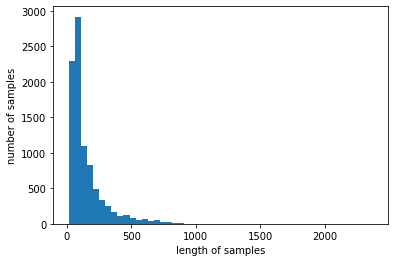

In [9]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

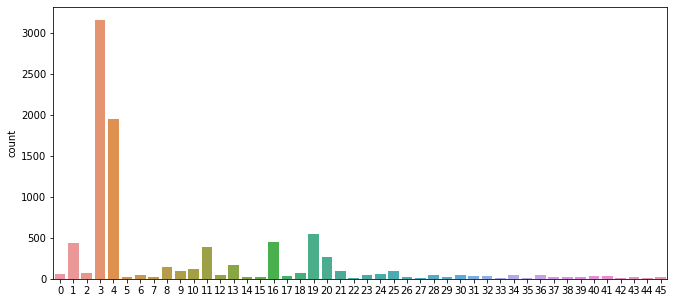

In [10]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [11]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 전처리

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [7]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [9]:
def decode_index(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    print(f'length: {len(decoded)}')
    return decoded

In [12]:
# tfidf 데이터로 변환
def get_dataset_tfidf(x_train, x_test):
    x_train_decoded = decode_index(x_train)
    x_test_decoded = decode_index(x_test)
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)
    tfidf_transformer = TfidfTransformer()
    tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_dtm = dtmvector.transform(x_test_decoded) #테스트 데이터를 DTM으로 변환
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    return tfidfv_train, tfidfv_test

In [88]:
tfidfv_train, tfidfv_test = get_dataset_tfidf(x_train, x_test)

length: 8982
length: 2246


In [89]:
dataset = {
    "X_train": tfidfv_train,
    "y_train": y_train,
    "X_test": tfidfv_test,
    "y_test": y_test
}

In [90]:
# 데이터셋 저장
save_var(dataset, prefix_name + "_" + "dataset")

### Fit

In [115]:
# 8개 분류기
def get_classifiers():
    classifiers = {
        'multinomial_nb': MultinomialNB(),
        'complement_nb': ComplementNB(),
        'logistic_regression': LogisticRegression(C=10000, penalty='l2', max_iter=3000, verbose=1),
        'linear_svc': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
        'decision_tree': DecisionTreeClassifier(max_depth=10, random_state=0),
        'random_forest': RandomForestClassifier(n_estimators=5, random_state=0),
        'gradient_boosting': GradientBoostingClassifier(random_state=0, verbose=1)
    }

    classifiers['voting'] = VotingClassifier(
        estimators=[('cb', classifiers['complement_nb']), 
                    ('lr', classifiers['logistic_regression']), 
                    ('gb', classifiers['gradient_boosting'])],
        voting='soft', verbose=1
    )

    classifiers = list(classifiers.items())
    
    return classifiers

In [116]:
# Parallel 사용하기 위한 fit 
def clf_fit(clf, clf_name, dataset, prefix_name="_"):
    
    # 그냥 갖다쓰면 오류남. 
    # Parallel 진행과정 중에서 뭔가 데이터를 변경하는듯.
    # 찾아보니 복사해서 쓰라고 함.
    X_train = dataset["X_train"].copy()
    X_test = dataset["X_test"].copy()
    y_train = dataset["y_train"].copy()
    y_test = dataset["y_test"].copy()

    results = {}
    
    # fit
    print(f"fit: {clf_name}")
    clf.fit(X_train, y_train)
    
    # 예측
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[clf_name] = accuracy
    print(f"{clf_name}: {accuracy:.2f}%")
    
    # save classifiers and results
    save_var(clf, name=f"{prefix_name}_{clf_name}")
    save_var(accuracy, name=f"{prefix_name}_{clf_name}_results")


In [117]:
classifiers = get_classifiers()

In [80]:
Parallel(n_jobs=-1, backend='loky')(delayed(clf_fit)(
    clf=clf, clf_name=clf_name, dataset=dataset, prefix_name=prefix_name) for clf_name, clf in classifiers)

INFO:root:Saved: wf_decision_tree.pkl (Size: 0.13 MB)
INFO:root:Saved: wf_decision_tree_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Saved: wf_random_forest.pkl (Size: 10.62 MB)
INFO:root:Saved: wf_random_forest_results.pkl (Size: 0.00 MB)


fit: random_forest
random_forest: 0.65%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.9min finished
INFO:root:Saved: wf_gradient_boosting.pkl (Size: 3.61 MB)
INFO:root:Saved: wf_gradient_boosting_results.pkl (Size: 0.00 MB)


fit: gradient_boosting
      Iter       Train Loss   Remaining Time 
         1           1.4301           18.92m
         2       76760.8864           18.16m
         3   766490025.2967           17.88m
         4 660857139232122368.0000           17.54m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           17.21m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.92m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.62m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.39m
         9 10065290604071140042756467323129516153113703767556134767592453772566748376920

INFO:root:Saved: wf_voting.pkl (Size: 31.87 MB)
INFO:root:Saved: wf_voting_results.pkl (Size: 0.00 MB)


[None, None, None, None]

- LMS 코어가 4개인데, 하나만 돌아가는듯...

## report, confusion matrix

In [10]:
def graph_confusion_matrix(model, x_test, y_test, title="title"):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.title(title)
    plt.ylabel('label')
    plt.xlabel('predicted value')


INFO:root:Loaded: wf_multinomial_nb.pkl (Size: 18.61 MB)


multinomial_nb result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
    

INFO:root:Loaded: wf_complement_nb.pkl (Size: 18.81 MB)


complement_nb result:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.88      0.73       105
           2       0.91      0.50      0.65        20
           3       0.87      0.91      0.89       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.43      0.08      0.13        38
           9       0.81      0.88      0.85        25
          10       0.96      0.73      0.83        30
          11       0.55      0.67      0.61        83
          12       0.00      0.00      0.00        13
          13       0.62      0.54      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.77      0.71        99
     

INFO:root:Loaded: wf_logistic_regression.pkl (Size: 9.30 MB)


logistic_regression result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.79      0.77       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.70        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.70      0.77      0.73        99

INFO:root:Loaded: wf_linear_svc.pkl (Size: 9.30 MB)


linear_svc result:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.72      0.74      0.73       105
           2       0.68      0.65      0.67        20
           3       0.90      0.92      0.91       813
           4       0.80      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.82      1.00      0.90        14
           7       1.00      0.33      0.50         3
           8       0.64      0.71      0.67        38
           9       0.81      0.88      0.85        25
          10       0.92      0.77      0.84        30
          11       0.69      0.75      0.72        83
          12       0.36      0.31      0.33        13
          13       0.62      0.57      0.59        37
          14       1.00      1.00      1.00         2
          15       0.56      0.56      0.56         9
          16       0.67      0.77      0.72        99
        

INFO:root:Loaded: wf_decision_tree.pkl (Size: 0.13 MB)


decision_tree result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.69      0.43      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.85      0.89       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.58      0.60      0.59        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.83      0.70        99
     

INFO:root:Loaded: wf_random_forest.pkl (Size: 10.62 MB)


random_forest result:
              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.35      0.60      0.44       105
           2       0.32      0.40      0.36        20
           3       0.82      0.89      0.85       813
           4       0.62      0.84      0.71       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.51      0.47      0.49        38
           9       1.00      0.28      0.44        25
          10       0.46      0.20      0.28        30
          11       0.56      0.64      0.60        83
          12       0.40      0.15      0.22        13
          13       0.33      0.16      0.22        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.46      0.52        99
     

INFO:root:Loaded: wf_gradient_boosting.pkl (Size: 3.61 MB)


gradient_boosting result:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.91      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10       0.79      0.77      0.78        30
          11       0.61      0.65      0.63        83
          12       0.50      0.46      0.48        13
          13       0.48      0.32      0.39        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.72      0.71      0.71        99
 

INFO:root:Loaded: wf_voting.pkl (Size: 31.87 MB)


voting result:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.75      0.77       105
           2       0.65      0.75      0.70        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.66      0.71      0.68        38
           9       0.83      0.80      0.82        25
          10       0.90      0.90      0.90        30
          11       0.67      0.70      0.69        83
          12       0.60      0.46      0.52        13
          13       0.67      0.65      0.66        37
          14       0.25      1.00      0.40         2
          15       0.50      0.22      0.31         9
          16       0.76      0.75      0.75        99
          17

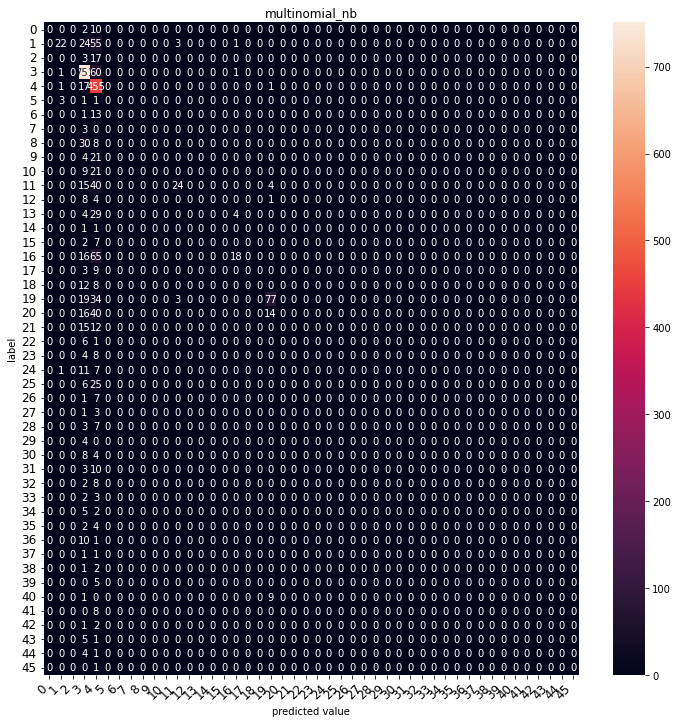

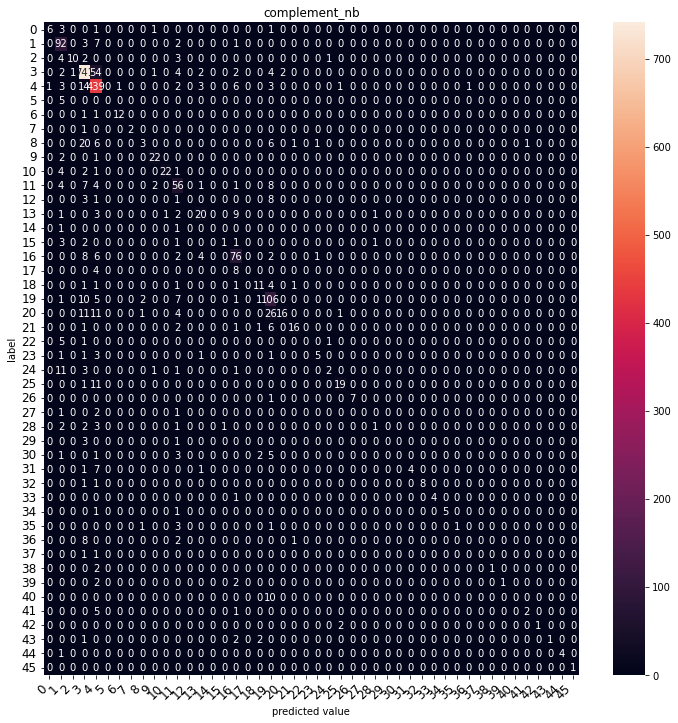

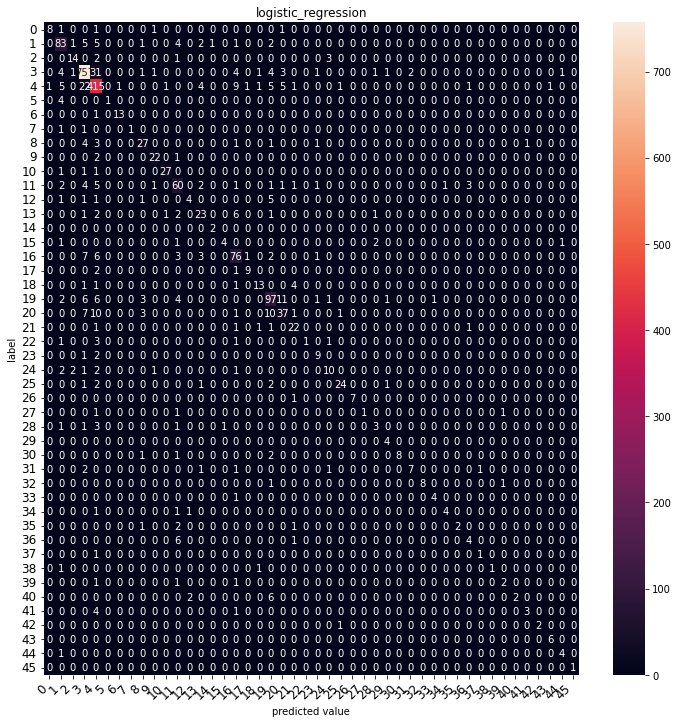

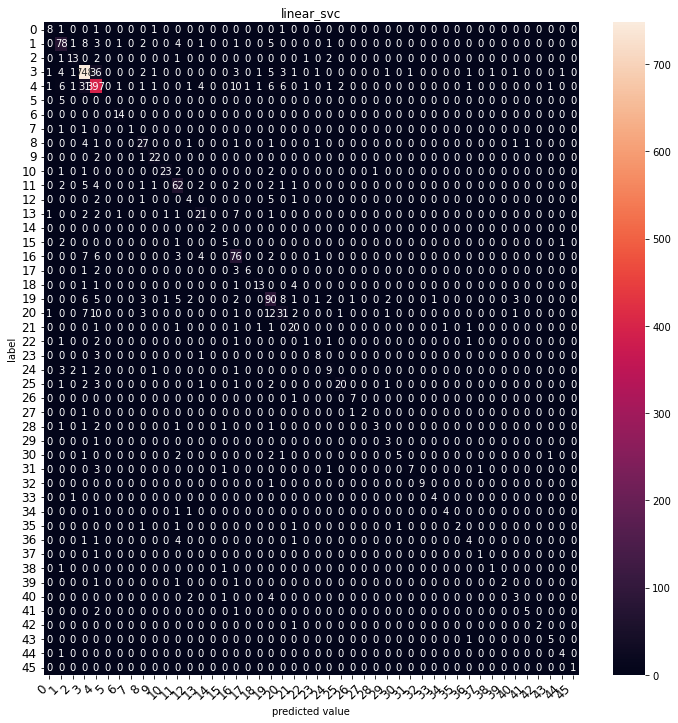

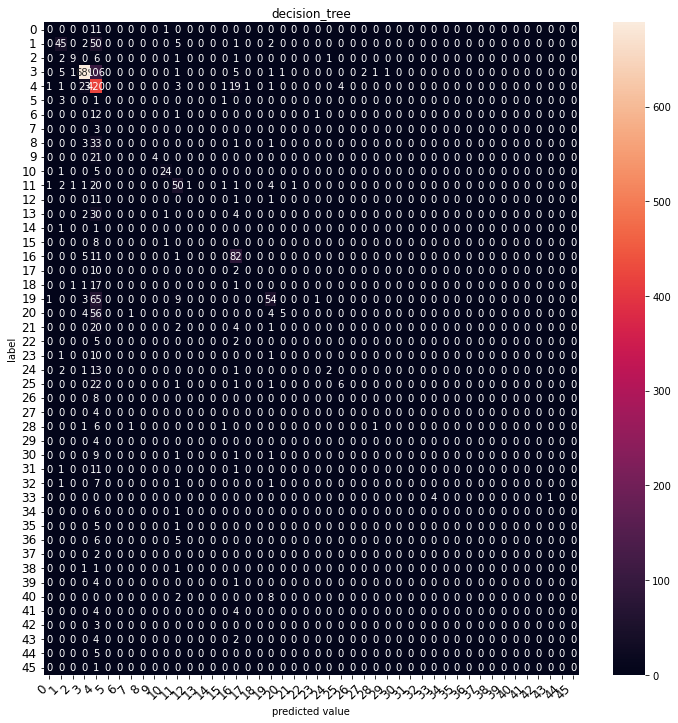

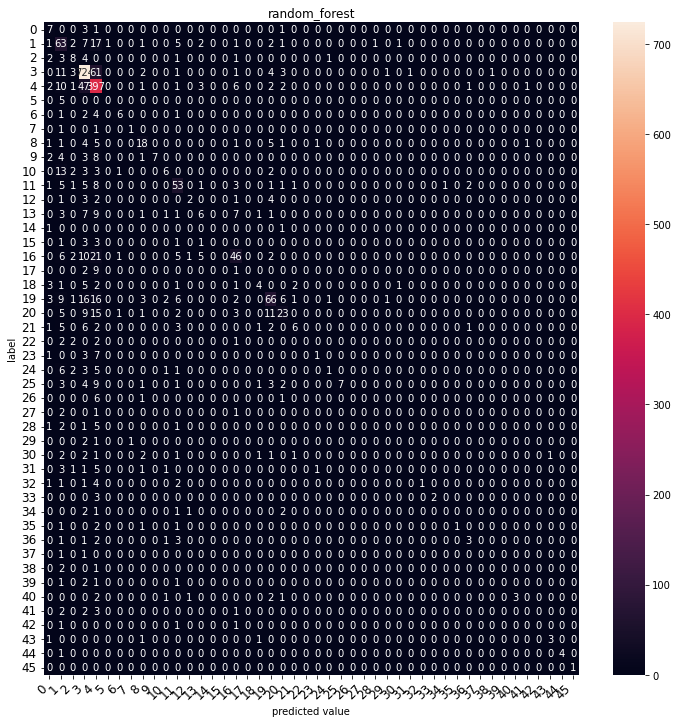

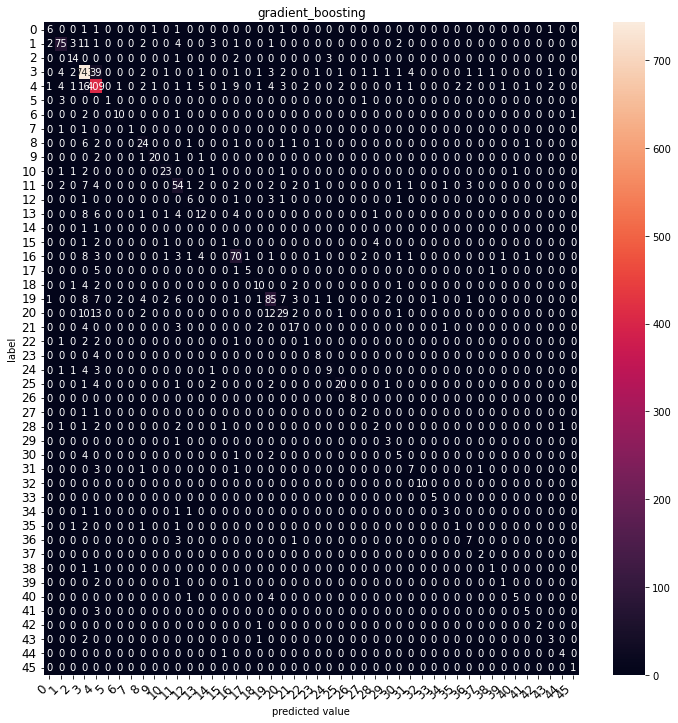

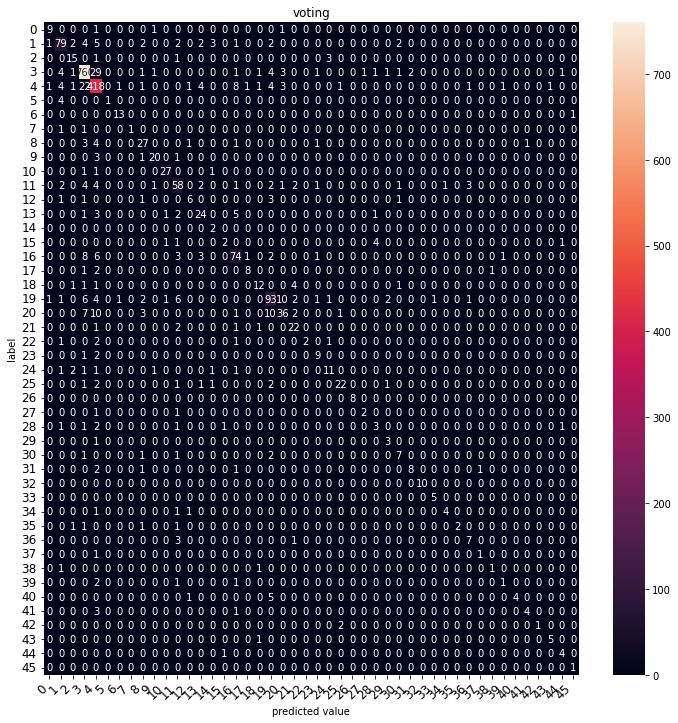

In [88]:
for clf_name, clf in classifiers:

    clf = load_var(prefix_name + "_" + clf_name)
    print(f"{clf_name} result:")
    print(classification_report(y_test, clf.predict(tfidfv_test), zero_division=0))
    graph_confusion_matrix(clf, tfidfv_test, y_test, title=clf_name)


# 2. 빈도수 상위 5,000개의 단어만 사용

In [91]:
prefix_name = "w5k"

In [92]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [93]:
tfidfv_train, tfidfv_test = get_dataset_tfidf(x_train, x_test)

length: 8982
length: 2246


In [94]:
dataset = {
    "X_train": tfidfv_train,
    "y_train": y_train,
    "X_test": tfidfv_test,
    "y_test": y_test
}

In [95]:
save_var(dataset, prefix_name + "_" + "dataset")

In [99]:
Parallel(n_jobs=-1, backend='loky')(delayed(clf_fit)(
    clf=clf, clf_name=clf_name, dataset=dataset, prefix_name=prefix_name) for clf_name, clf in classifiers)

INFO:root:Saved: w5k_multinomial_nb.pkl (Size: 3.42 MB)
INFO:root:Saved: w5k_multinomial_nb_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Saved: w5k_complement_nb.pkl (Size: 3.45 MB)
INFO:root:Saved: w5k_complement_nb_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w5k_decision_tree.pkl (Size: 0.14 MB)
INFO:root:Saved: w5k_decision_tree_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w5k_random_forest.pkl (Size: 8.43 MB)
INFO:root:Saved: w5k_random_forest_results.pkl (Size: 0.00 MB)
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
INFO:root:Saved: w5k_linear_svc.pkl (Size: 1.71 MB)
INFO:root:Saved: w5k_linear_svc_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min finished
INFO:root:Save

fit: logistic_regression
logistic_regression: 0.80%
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       223928     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43889D+04    |proj g|=  2.96374D+03

At iterate   50    f=  1.45155D+03    |proj g|=  2.20076D+01

At iterate  100    f=  4.95515D+02    |proj g|=  2.31397D+00

At iterate  150    f=  4.67339D+02    |proj g|=  4.61780D-01

At iterate  200    f=  4.65438D+02    |proj g|=  8.36896D-01

At iterate  250    f=  4.63098D+02    |proj g|=  6.25565D-01

At iterate  300    f=  4.61270D+02    |proj g|=  2.81432D-01

At iterate  350    f=  4.59094D+02    |proj g|=  6.34904D-01

At iterate  400    f=  4.57276D+02    |proj g|=  4.93816D-01

At iterate  450    f=  4.55645D+02    |proj g|=  1.06894D-01

At iterate  500    f=  4.53997D+02    |proj g|=  3.22604D-01

At iterate  550    f=  4.52783D+02    |proj g|=  1.84626D-01

At iterate  600    f=  4.51938D+02  

 This problem is unconstrained.
INFO:root:Saved: w5k_gradient_boosting.pkl (Size: 3.91 MB)
INFO:root:Saved: w5k_gradient_boosting_results.pkl (Size: 0.00 MB)


fit: complement_nb
complement_nb: 0.77%
fit: decision_tree
decision_tree: 0.62%
fit: random_forest
random_forest: 0.70%
fit: gradient_boosting
      Iter       Train Loss   Remaining Time 
         1           1.4697           22.22m
         2     2131099.0239           22.19m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           22.01m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           21.78m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           21.59m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           21.43m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.

INFO:root:Saved: w5k_voting.pkl (Size: 9.22 MB)
INFO:root:Saved: w5k_voting_results.pkl (Size: 0.00 MB)


[None, None, None, None, None, None, None, None]

INFO:root:Loaded: w5k_multinomial_nb.pkl (Size: 3.42 MB)


multinomial_nb result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
    

INFO:root:Loaded: w5k_complement_nb.pkl (Size: 3.45 MB)


complement_nb result:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.63      0.86      0.73       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.74      0.92      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.57      0.21      0.31        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.76      0.63        83
          12       0.00      0.00      0.00        13
          13       0.69      0.59      0.64        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.67      0.79      0.72        99
     

INFO:root:Loaded: w5k_logistic_regression.pkl (Size: 1.71 MB)


logistic_regression result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.77      0.75       105
           2       0.76      0.80      0.78        20
           3       0.90      0.92      0.91       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.71      0.69        38
           9       0.81      0.88      0.85        25
          10       0.89      0.83      0.86        30
          11       0.65      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.63      0.65      0.64        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46         9
          16       0.70      0.75      0.72        99

INFO:root:Loaded: w5k_linear_svc.pkl (Size: 1.71 MB)


linear_svc result:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.68      0.69      0.68       105
           2       0.74      0.70      0.72        20
           3       0.90      0.89      0.89       813
           4       0.81      0.83      0.82       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       0.50      0.33      0.40         3
           8       0.57      0.66      0.61        38
           9       0.81      0.84      0.82        25
          10       0.75      0.80      0.77        30
          11       0.66      0.76      0.71        83
          12       0.44      0.31      0.36        13
          13       0.54      0.59      0.56        37
          14       0.50      1.00      0.67         2
          15       0.67      0.22      0.33         9
          16       0.63      0.69      0.66        99
        

INFO:root:Loaded: w5k_decision_tree.pkl (Size: 0.14 MB)


decision_tree result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.40      0.52       105
           2       0.60      0.45      0.51        20
           3       0.94      0.84      0.89       813
           4       0.39      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       1.00      0.57      0.73        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.62      0.48      0.54        83
          12       0.17      0.08      0.11        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.82      0.69        99
     

INFO:root:Loaded: w5k_random_forest.pkl (Size: 8.43 MB)


random_forest result:
              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      0.67      0.68        99
     

INFO:root:Loaded: w5k_gradient_boosting.pkl (Size: 3.91 MB)


gradient_boosting result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
          16       0.72      0.77      0.75        99
 

INFO:root:Loaded: w5k_voting.pkl (Size: 9.22 MB)


voting result:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.73      0.76       105
           2       0.65      0.65      0.65        20
           3       0.91      0.94      0.92       813
           4       0.82      0.87      0.84       474
           5       0.50      0.20      0.29         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.68      0.68        38
           9       0.78      0.84      0.81        25
          10       0.93      0.87      0.90        30
          11       0.67      0.72      0.70        83
          12       0.60      0.46      0.52        13
          13       0.65      0.65      0.65        37
          14       0.10      0.50      0.17         2
          15       0.60      0.33      0.43         9
          16       0.75      0.75      0.75        99
          17

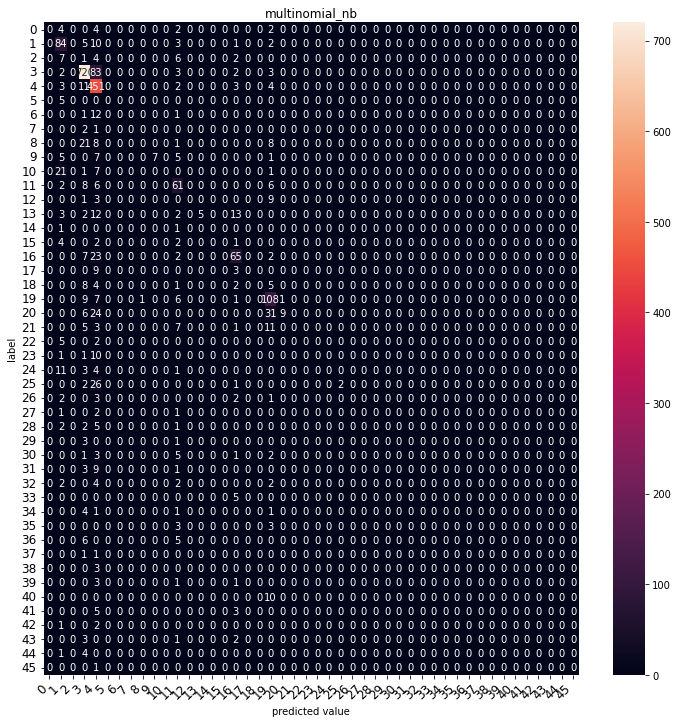

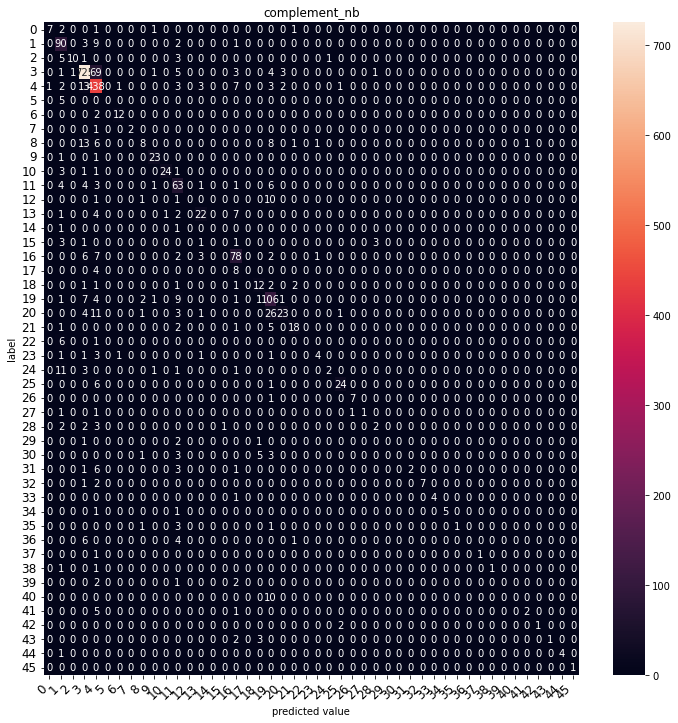

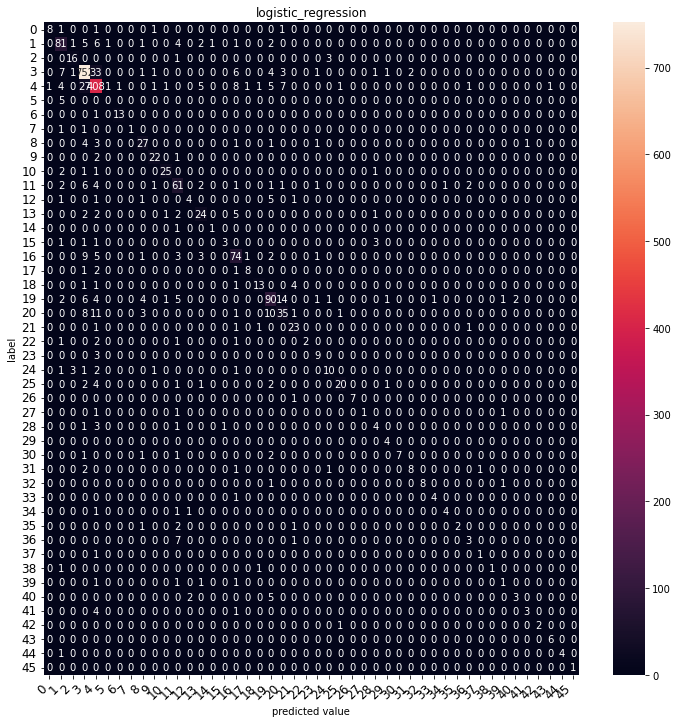

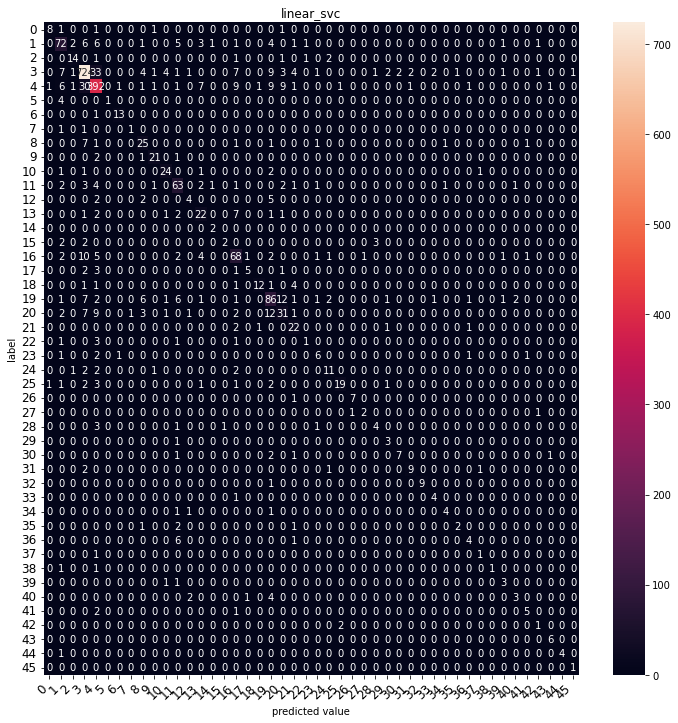

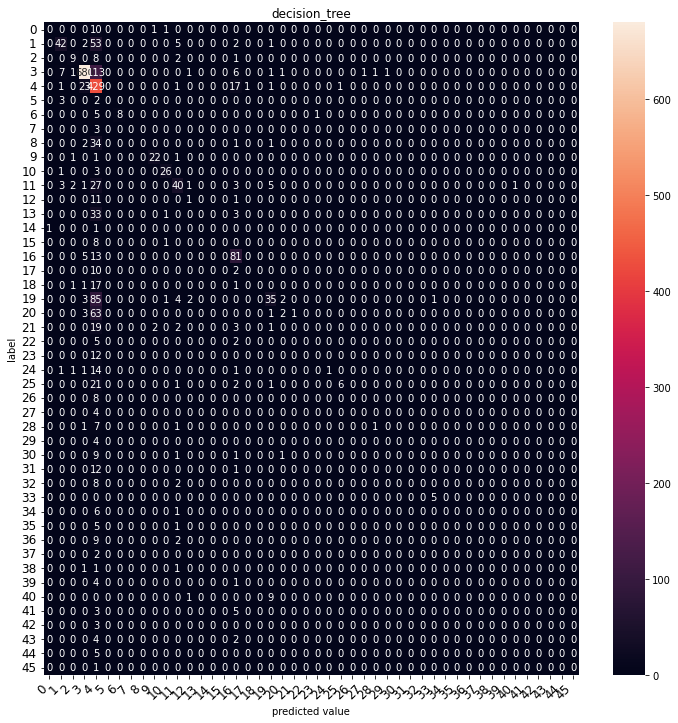

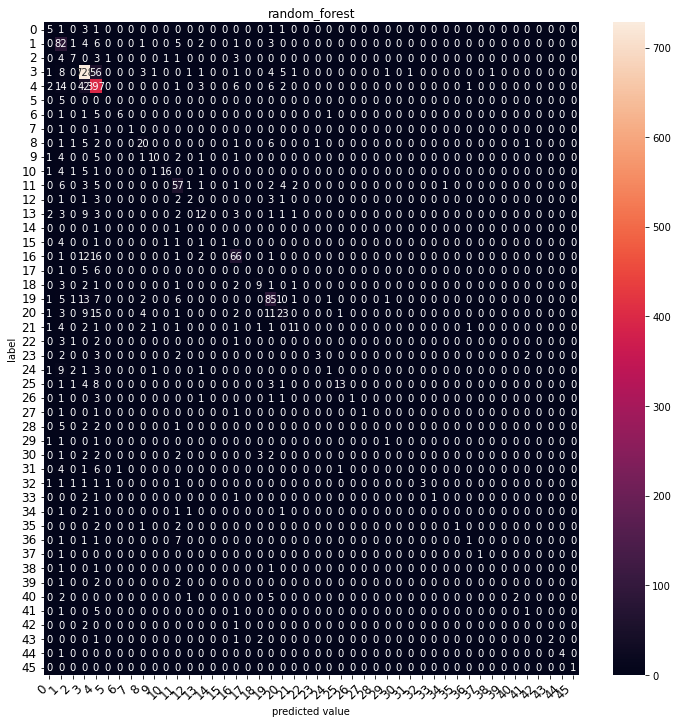

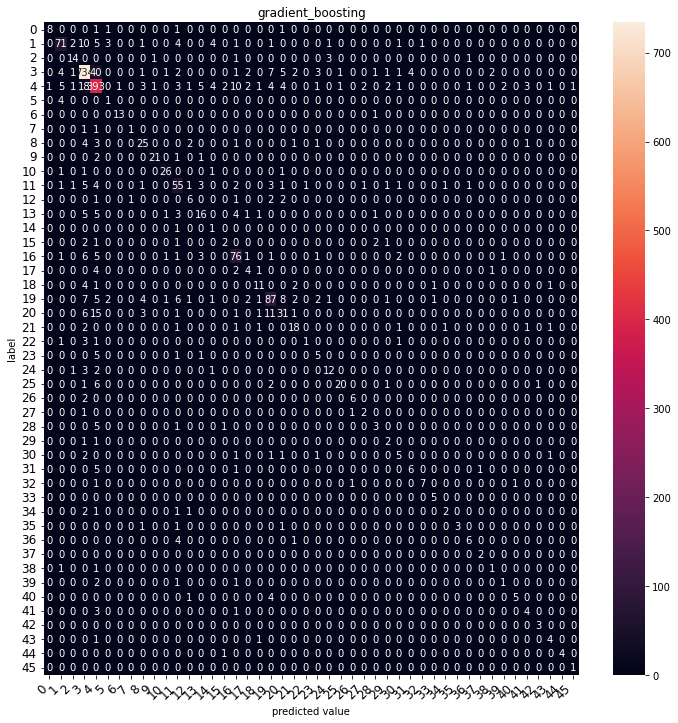

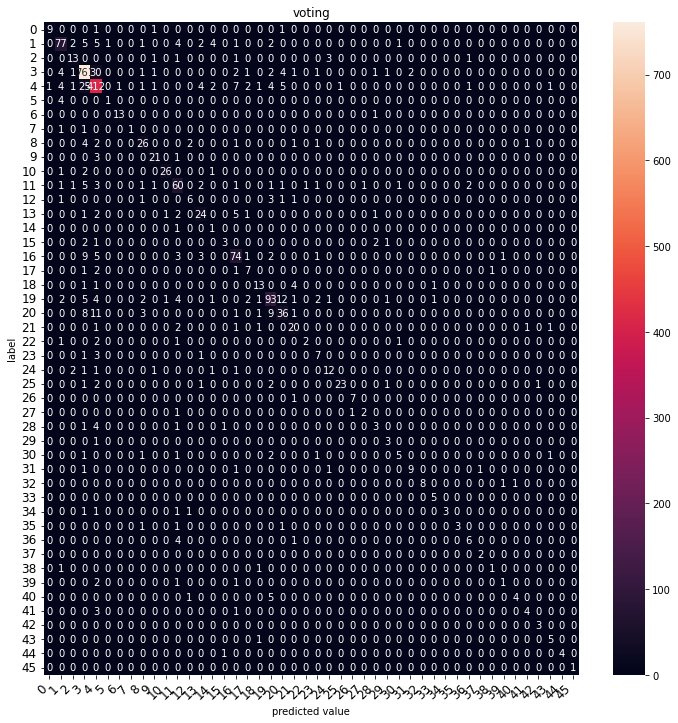

In [100]:
for clf_name, clf in classifiers:

    clf = load_var(prefix_name + "_" + clf_name)
    print(f"{clf_name} result:")
    print(classification_report(y_test, clf.predict(tfidfv_test), zero_division=0))
    graph_confusion_matrix(clf, tfidfv_test, y_test, title=clf_name)

# 3. 직접 단어 개수를 설정해서 사용

## 15,000 단어 사용

In [96]:
prefix_name = "w15k"

In [97]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

In [98]:
tfidfv_train, tfidfv_test = get_dataset_tfidf(x_train, x_test)

length: 8982
length: 2246


In [99]:
dataset = {
    "X_train": tfidfv_train,
    "y_train": y_train,
    "X_test": tfidfv_test,
    "y_test": y_test
}

In [100]:
save_var(dataset, prefix_name + "_" + "dataset")

In [205]:
classifiers = get_classifiers()

In [110]:
Parallel(n_jobs=-1, backend='loky')(delayed(clf_fit)(
    clf=clf, clf_name=clf_name, dataset=dataset, prefix_name=prefix_name) for clf_name, clf in classifiers)

INFO:root:Saved: w15k_multinomial_nb.pkl (Size: 9.99 MB)
INFO:root:Saved: w15k_multinomial_nb_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w15k_complement_nb.pkl (Size: 10.10 MB)
INFO:root:Saved: w15k_complement_nb_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Saved: w15k_decision_tree.pkl (Size: 0.15 MB)
INFO:root:Saved: w15k_decision_tree_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w15k_random_forest.pkl (Size: 9.71 MB)
INFO:root:Saved: w15k_random_forest_results.pkl (Size: 0.00 MB)
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
INFO:root:Saved: w15k_linear_svc.pkl (Size: 4.99 MB)
INFO:root:Saved: w15k_linear_svc_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished
INF

fit: multinomial_nb
multinomial_nb: 0.67%
fit: linear_svc
linear_svc: 0.77%
fit: voting
[Voting] ....................... (1 of 3) Processing cb, total=   0.0s
[Voting] ....................... (2 of 3) Processing lr, total= 3.9min
      Iter       Train Loss   Remaining Time 
         1           1.4697           14.40m
         2     2131099.0239           14.57m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           14.44m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           14.28m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           14.13m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           14.01m
         7 4430672995303016599803743635259499956296955496915598

 This problem is unconstrained.
 This problem is unconstrained.
INFO:root:Saved: w15k_gradient_boosting.pkl (Size: 3.62 MB)
INFO:root:Saved: w15k_gradient_boosting_results.pkl (Size: 0.00 MB)


fit: decision_tree
decision_tree: 0.62%
fit: random_forest
random_forest: 0.67%
fit: gradient_boosting
      Iter       Train Loss   Remaining Time 
         1           1.4326           19.54m
         2       81331.2398           17.94m
         3     5836811.5076           18.66m
         4 63789339395313685793847548538268197034083221504000.0000           19.64m
         5 196168839837262027401908577577888497468749556189708834227594295318514495389696.0000           18.75m
         6 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           18.11m
         7 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           17.78m
         8 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           17.83m
         9 19592378563466554644986962471065419451420924881

INFO:root:Saved: w15k_voting.pkl (Size: 18.86 MB)
INFO:root:Saved: w15k_voting_results.pkl (Size: 0.00 MB)


[None, None, None, None, None, None, None, None]

INFO:root:Loaded: w15k_multinomial_nb.pkl (Size: 9.99 MB)


multinomial_nb result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.41      0.53        99
    

INFO:root:Loaded: w15k_complement_nb.pkl (Size: 10.10 MB)


complement_nb result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.65      0.90      0.76       105
           2       0.91      0.50      0.65        20
           3       0.90      0.90      0.90       813
           4       0.76      0.93      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.71      0.61        83
          12       0.00      0.00      0.00        13
          13       0.60      0.57      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.68      0.79      0.73        99
     

INFO:root:Loaded: w15k_logistic_regression.pkl (Size: 4.99 MB)


logistic_regression result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.79      0.76       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.92       813
           4       0.81      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.85      0.88      0.86        25
          10       0.93      0.87      0.90        30
          11       0.68      0.72      0.70        83
          12       0.62      0.38      0.48        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.71      0.77      0.74        99

INFO:root:Loaded: w15k_linear_svc.pkl (Size: 4.99 MB)


linear_svc result:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.71      0.73      0.72       105
           2       0.76      0.65      0.70        20
           3       0.90      0.92      0.91       813
           4       0.82      0.86      0.84       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       0.50      0.33      0.40         3
           8       0.60      0.68      0.64        38
           9       0.92      0.88      0.90        25
          10       0.92      0.80      0.86        30
          11       0.66      0.73      0.69        83
          12       0.42      0.38      0.40        13
          13       0.62      0.54      0.58        37
          14       0.50      1.00      0.67         2
          15       0.67      0.67      0.67         9
          16       0.63      0.74      0.68        99
        

INFO:root:Loaded: w15k_decision_tree.pkl (Size: 0.15 MB)


decision_tree result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.73      0.42      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.83      0.88       813
           4       0.40      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.86      0.80      0.83        30
          11       0.64      0.49      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.82      0.70        99
     

INFO:root:Loaded: w15k_random_forest.pkl (Size: 9.71 MB)


random_forest result:
              precision    recall  f1-score   support

           0       0.25      0.50      0.33        12
           1       0.42      0.69      0.52       105
           2       0.13      0.10      0.11        20
           3       0.81      0.90      0.85       813
           4       0.65      0.85      0.74       474
           5       0.00      0.00      0.00         5
           6       0.83      0.36      0.50        14
           7       0.50      0.67      0.57         3
           8       0.62      0.53      0.57        38
           9       0.71      0.40      0.51        25
          10       0.60      0.20      0.30        30
          11       0.45      0.51      0.47        83
          12       0.60      0.23      0.33        13
          13       0.40      0.22      0.28        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.55      0.46      0.50        99
     

INFO:root:Loaded: w15k_gradient_boosting.pkl (Size: 3.62 MB)


gradient_boosting result:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.70      0.74       105
           2       0.62      0.65      0.63        20
           3       0.88      0.91      0.89       813
           4       0.78      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       0.83      0.71      0.77        14
           7       1.00      0.67      0.80         3
           8       0.59      0.63      0.61        38
           9       0.86      0.76      0.81        25
          10       0.86      0.80      0.83        30
          11       0.64      0.67      0.66        83
          12       0.35      0.54      0.42        13
          13       0.54      0.41      0.46        37
          14       0.08      0.50      0.13         2
          15       0.38      0.33      0.35         9
          16       0.72      0.74      0.73        99
 

INFO:root:Loaded: w15k_voting.pkl (Size: 18.86 MB)


voting result:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.75      0.76       105
           2       0.75      0.75      0.75        20
           3       0.92      0.94      0.93       813
           4       0.82      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.65      0.68      0.67        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.68      0.72      0.70        83
          12       0.43      0.46      0.44        13
          13       0.69      0.65      0.67        37
          14       0.10      0.50      0.17         2
          15       0.57      0.44      0.50         9
          16       0.73      0.77      0.75        99
          17

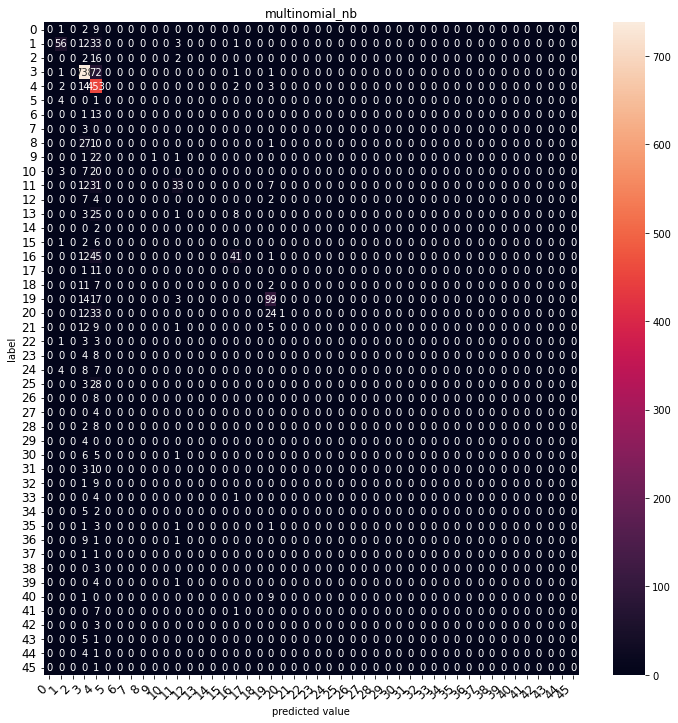

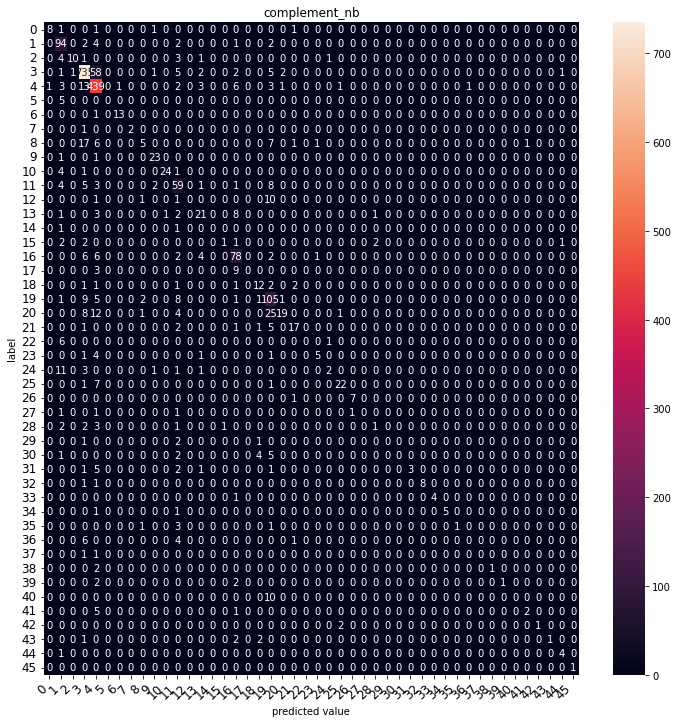

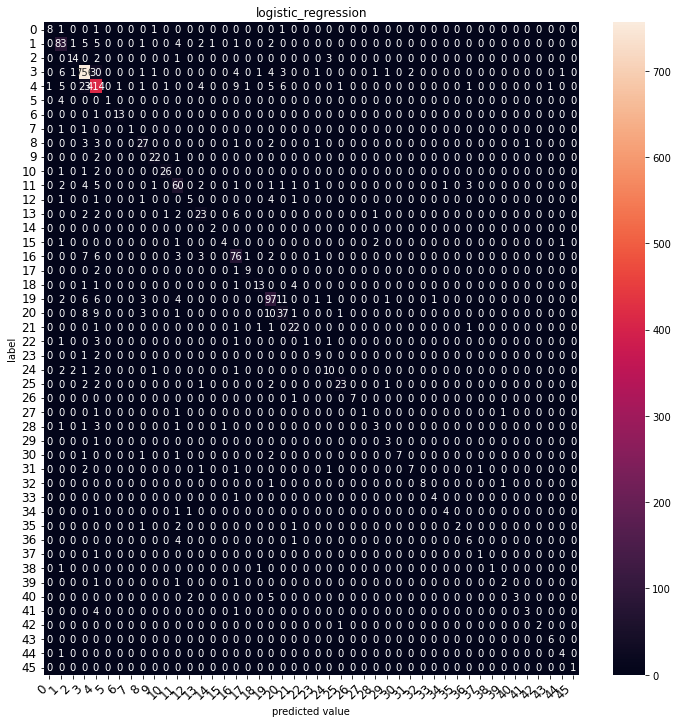

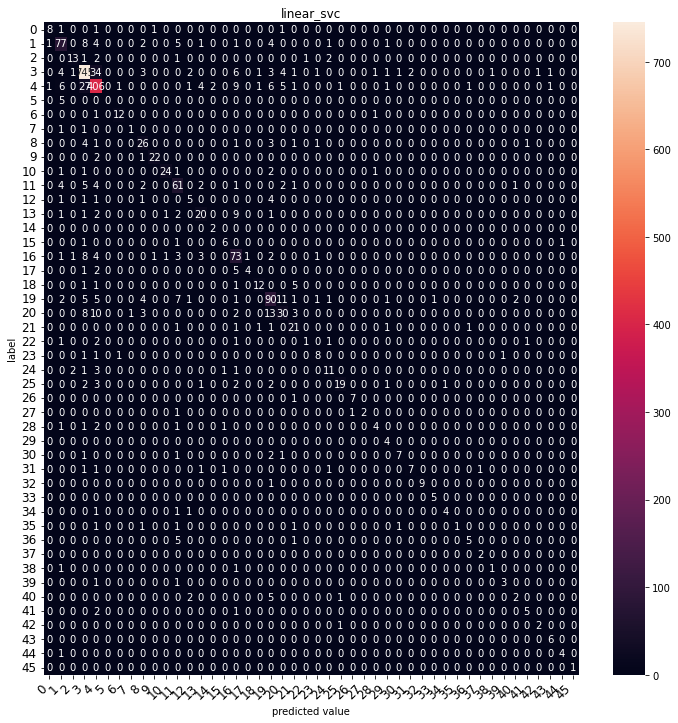

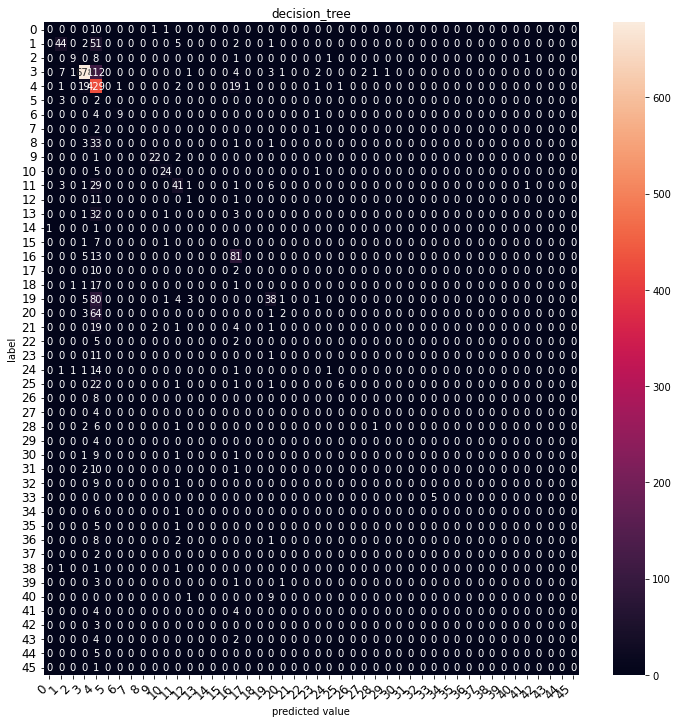

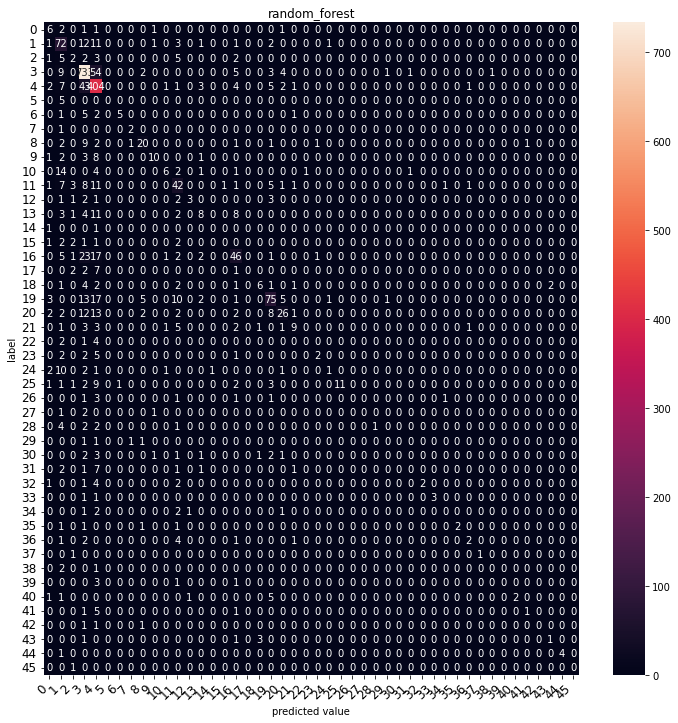

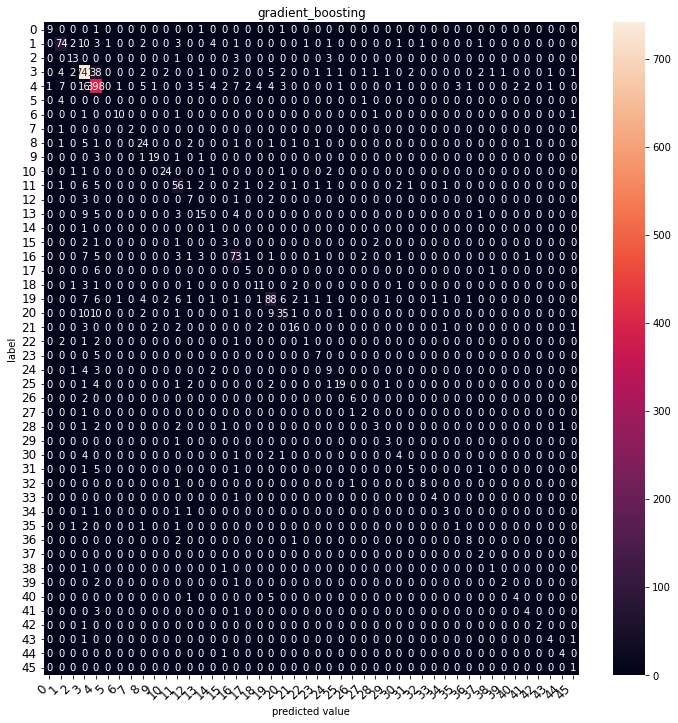

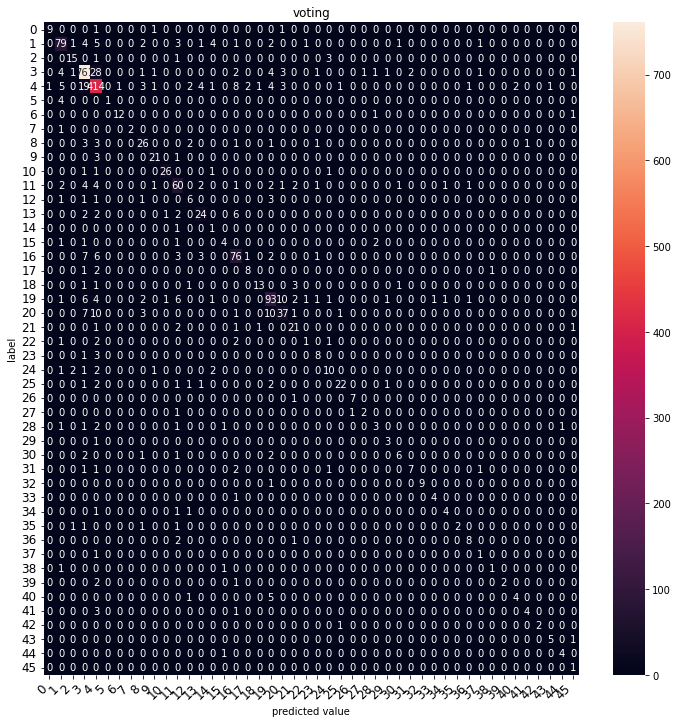

fit: linear_svc
linear_svc: 0.79%
fit: voting
[Voting] ....................... (1 of 3) Processing cb, total=   0.1s
[Voting] ....................... (2 of 3) Processing lr, total= 6.1min
      Iter       Train Loss   Remaining Time 
         1           1.4326           15.45m
         2       81331.2398           15.42m
         3     5836811.5076           15.29m
         4 63789339395313685793847548538268197034083221504000.0000           15.15m
         5 196168839837262027401908577577888497468749556189708834227594295318514495389696.0000           15.01m
         6 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           14.88m
         7 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           14.74m
         8 19592378563466554644986962471065419451420924881287390475776790084823084277053994400039626580885787303357243696393224

 This problem is unconstrained.


In [111]:
for clf_name, clf in classifiers:

    clf = load_var(prefix_name + "_" + clf_name)
    print(f"{clf_name} result:")
    print(classification_report(y_test, clf.predict(tfidfv_test), zero_division=0))
    graph_confusion_matrix(clf, tfidfv_test, y_test, title=clf_name)

## 3,000 단어 사용

In [101]:
prefix_name = "w3k"

In [102]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

In [103]:
tfidfv_train, tfidfv_test = get_dataset_tfidf(x_train, x_test)

length: 8982
length: 2246


In [104]:
dataset = {
    "X_train": tfidfv_train,
    "y_train": y_train,
    "X_test": tfidfv_test,
    "y_test": y_test
}

In [105]:
save_var(dataset, prefix_name + "_" + "dataset")

In [201]:
classifiers = get_classifiers()

In [122]:
Parallel(n_jobs=-1, backend='loky')(delayed(clf_fit)(
    clf=clf, clf_name=clf_name, dataset=dataset, prefix_name="w3k") for clf_name, clf in classifiers)

INFO:root:Saved: w3k_multinomial_nb.pkl (Size: 2.05 MB)
INFO:root:Saved: w3k_multinomial_nb_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w3k_complement_nb.pkl (Size: 2.07 MB)
INFO:root:Saved: w3k_complement_nb_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Saved: w3k_decision_tree.pkl (Size: 0.14 MB)
INFO:root:Saved: w3k_decision_tree_results.pkl (Size: 0.00 MB)
INFO:root:Saved: w3k_random_forest.pkl (Size: 7.99 MB)
INFO:root:Saved: w3k_random_forest_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
INFO:root:Saved: w3k_logistic_regression.pkl (Size: 1.03 MB)
INFO:root:Saved: w3k_logistic_regression_results.pkl (Size: 0.00 MB)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

fit: multinomial_nb
multinomial_nb: 0.69%
fit: linear_svc
linear_svc: 0.75%


INFO:root:Saved: w3k_gradient_boosting.pkl (Size: 3.83 MB)
INFO:root:Saved: w3k_gradient_boosting_results.pkl (Size: 0.00 MB)


fit: complement_nb
complement_nb: 0.76%
fit: decision_tree
decision_tree: 0.63%
fit: random_forest
random_forest: 0.69%
fit: gradient_boosting
      Iter       Train Loss   Remaining Time 
         1           1.4761           14.43m
         2       29810.4893           14.47m
         3 103018026703.3806           14.29m
         4 111593327959535219617691187806208.0000           14.13m
         5 1904496955476400955779467607778270076434921719903327597388087378686114846508037997135967451479015424.0000           14.00m
         6 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.91m
         7 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.79m
         8 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.72m
         9 2359562257

INFO:root:Saved: w3k_voting.pkl (Size: 7.08 MB)
INFO:root:Saved: w3k_voting_results.pkl (Size: 0.00 MB)


[None, None, None, None, None, None, None, None]

INFO:root:Loaded: w3k_multinomial_nb.pkl (Size: 2.05 MB)


multinomial_nb result:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.49      0.82      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.64      0.95      0.76       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.10      0.18        30
          11       0.45      0.76      0.56        83
          12       0.00      0.00      0.00        13
          13       0.70      0.19      0.30        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.56      0.76      0.64        99
    

INFO:root:Loaded: w3k_complement_nb.pkl (Size: 2.07 MB)


complement_nb result:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.64      0.85      0.73       105
           2       0.83      0.50      0.62        20
           3       0.92      0.89      0.90       813
           4       0.74      0.93      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.64      0.18      0.29        38
           9       0.82      0.92      0.87        25
          10       0.93      0.83      0.88        30
          11       0.52      0.78      0.62        83
          12       0.00      0.00      0.00        13
          13       0.68      0.62      0.65        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.64      0.78      0.70        99
     

INFO:root:Loaded: w3k_logistic_regression.pkl (Size: 1.03 MB)


logistic_regression result:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.72      0.73       105
           2       0.79      0.75      0.77        20
           3       0.89      0.92      0.90       813
           4       0.79      0.83      0.81       474
           5       0.25      0.20      0.22         5
           6       0.93      1.00      0.97        14
           7       1.00      0.33      0.50         3
           8       0.63      0.71      0.67        38
           9       0.81      0.84      0.82        25
          10       0.86      0.83      0.85        30
          11       0.62      0.72      0.67        83
          12       0.62      0.38      0.48        13
          13       0.60      0.65      0.62        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46         9
          16       0.69      0.73      0.71        99

INFO:root:Loaded: w3k_linear_svc.pkl (Size: 1.03 MB)


linear_svc result:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.75      0.68      0.71       105
           2       0.70      0.70      0.70        20
           3       0.87      0.89      0.88       813
           4       0.78      0.80      0.79       474
           5       0.67      0.40      0.50         5
           6       0.87      0.93      0.90        14
           7       0.67      0.67      0.67         3
           8       0.58      0.68      0.63        38
           9       0.72      0.72      0.72        25
          10       0.77      0.80      0.79        30
          11       0.61      0.69      0.64        83
          12       0.36      0.31      0.33        13
          13       0.54      0.57      0.55        37
          14       0.50      0.50      0.50         2
          15       0.80      0.44      0.57         9
          16       0.66      0.68      0.67        99
        

INFO:root:Loaded: w3k_decision_tree.pkl (Size: 0.14 MB)


decision_tree result:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.39      0.51       105
           2       0.75      0.45      0.56        20
           3       0.94      0.84      0.89       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.59      0.52      0.55        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.84      0.70        99
     

INFO:root:Loaded: w3k_random_forest.pkl (Size: 7.99 MB)


random_forest result:
              precision    recall  f1-score   support

           0       0.30      0.58      0.40        12
           1       0.44      0.72      0.55       105
           2       0.12      0.10      0.11        20
           3       0.85      0.91      0.88       813
           4       0.66      0.83      0.73       474
           5       0.00      0.00      0.00         5
           6       0.67      0.57      0.62        14
           7       0.33      0.33      0.33         3
           8       0.54      0.53      0.53        38
           9       0.69      0.44      0.54        25
          10       0.72      0.43      0.54        30
          11       0.54      0.59      0.56        83
          12       0.50      0.15      0.24        13
          13       0.41      0.32      0.36        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.52      0.56        99
     

INFO:root:Loaded: w3k_gradient_boosting.pkl (Size: 3.83 MB)


gradient_boosting result:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.76      0.70      0.73       105
           2       0.67      0.70      0.68        20
           3       0.89      0.92      0.91       813
           4       0.77      0.84      0.80       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       0.20      0.33      0.25         3
           8       0.62      0.66      0.64        38
           9       0.90      0.76      0.83        25
          10       0.86      0.80      0.83        30
          11       0.66      0.69      0.67        83
          12       0.21      0.23      0.22        13
          13       0.54      0.41      0.46        37
          14       0.50      1.00      0.67         2
          15       0.50      0.22      0.31         9
          16       0.71      0.71      0.71        99
 

INFO:root:Loaded: w3k_voting.pkl (Size: 7.08 MB)


voting result:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.76      0.75      0.76       105
           2       0.65      0.75      0.70        20
           3       0.91      0.94      0.92       813
           4       0.82      0.86      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.65      0.74      0.69        38
           9       0.80      0.80      0.80        25
          10       0.93      0.87      0.90        30
          11       0.64      0.70      0.67        83
          12       0.50      0.38      0.43        13
          13       0.62      0.62      0.62        37
          14       0.67      1.00      0.80         2
          15       0.60      0.33      0.43         9
          16       0.71      0.73      0.72        99
          17

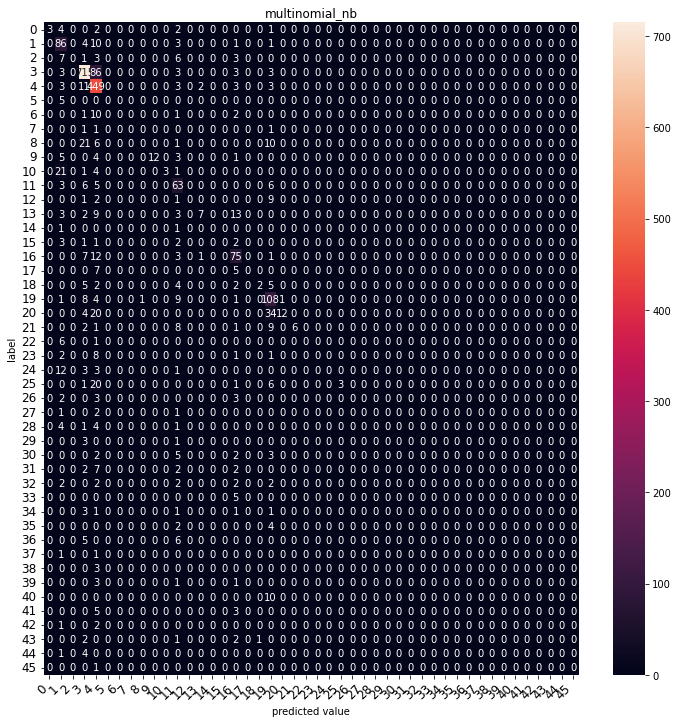

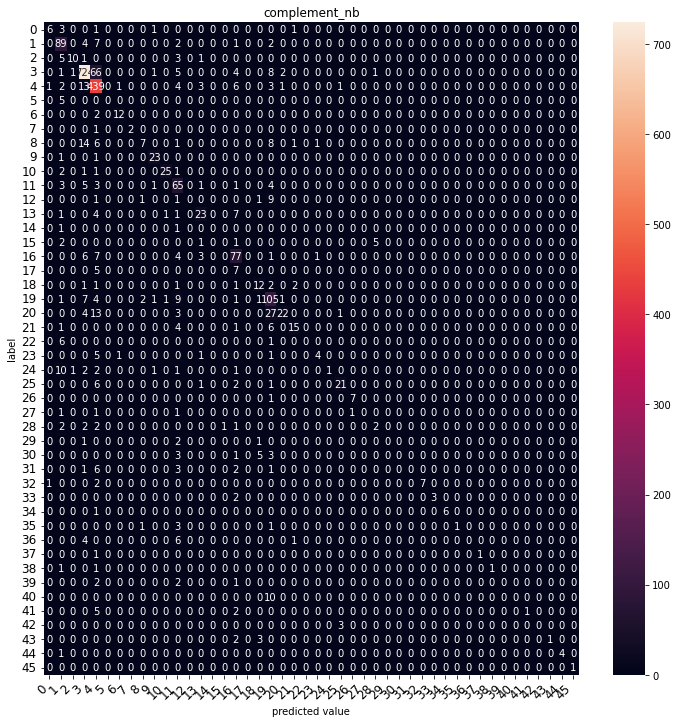

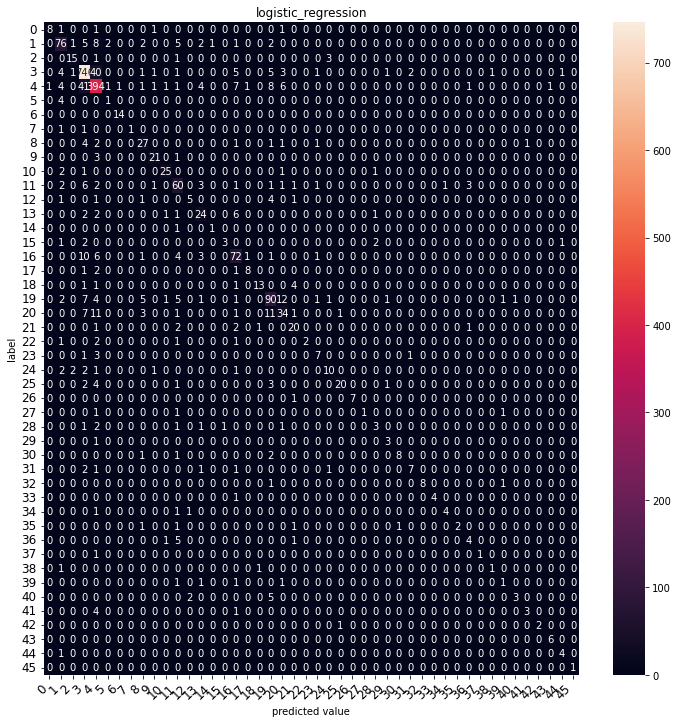

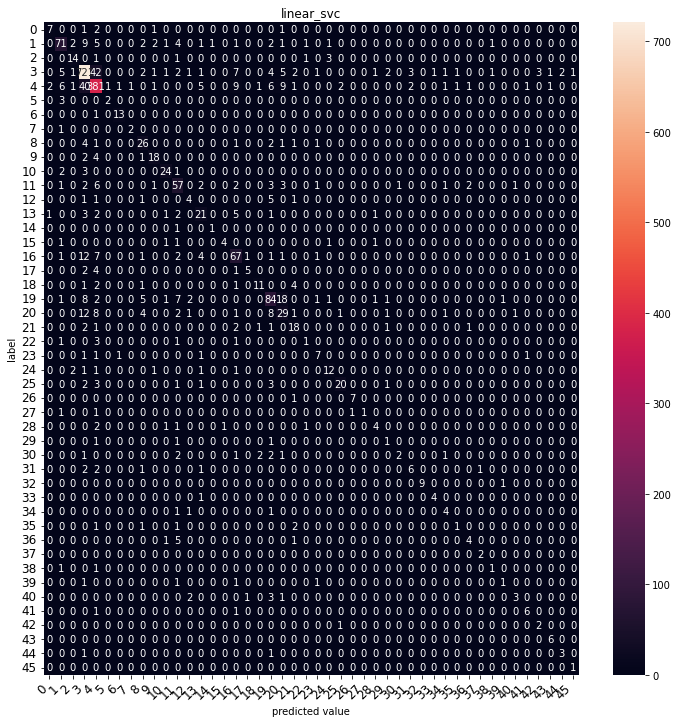

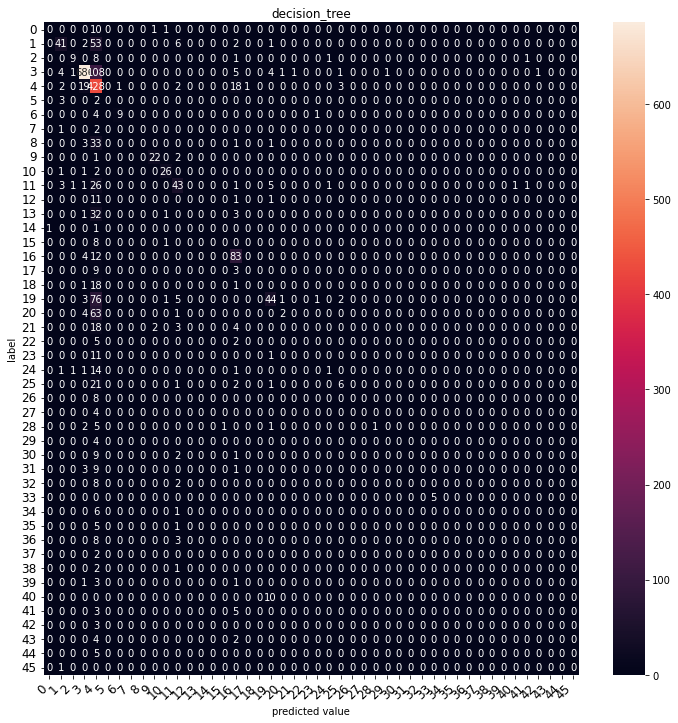

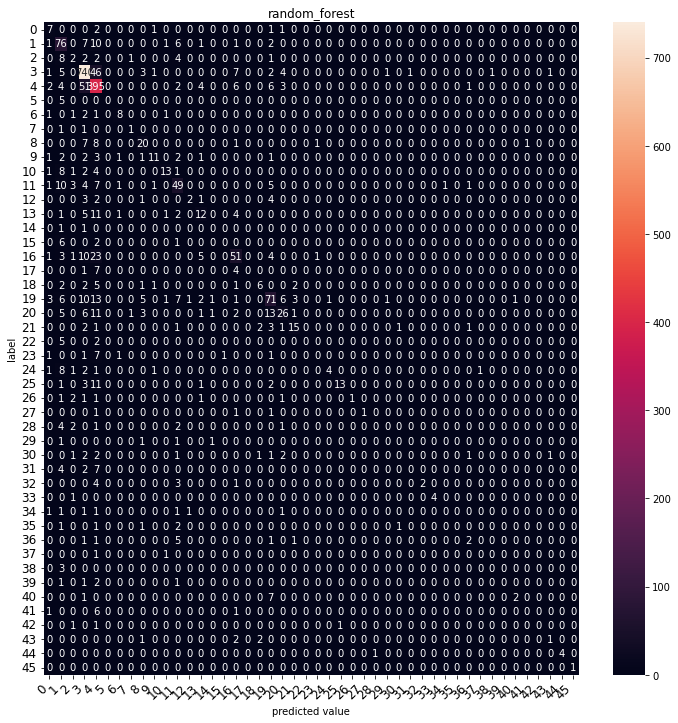

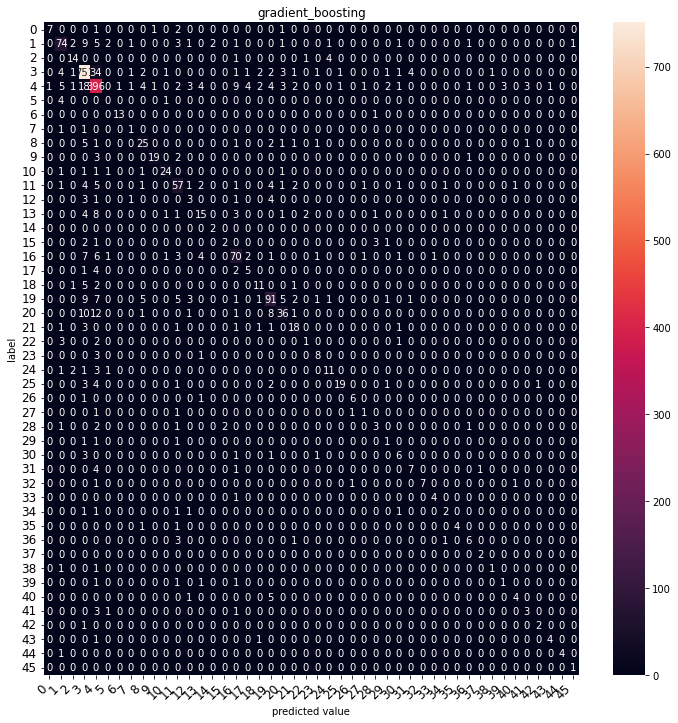

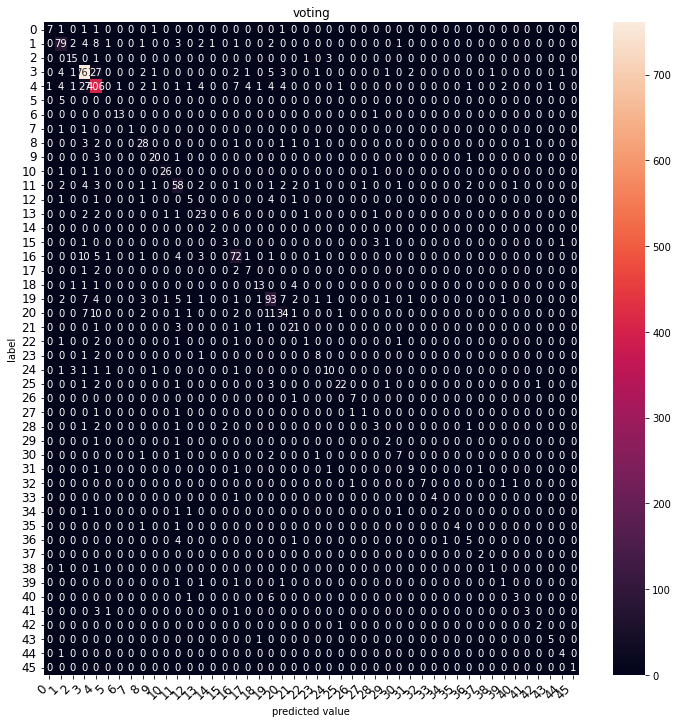

fit: logistic_regression
logistic_regression: 0.79%
fit: voting
[Voting] ....................... (1 of 3) Processing cb, total=   0.0s
[Voting] ....................... (2 of 3) Processing lr, total= 2.9min
      Iter       Train Loss   Remaining Time 
         1           1.4761           13.65m
         2       29810.4893           13.79m
         3 103018026703.3806           13.63m
         4 111593327959535219617691187806208.0000           13.58m
         5 1904496955476400955779467607778270076434921719903327597388087378686114846508037997135967451479015424.0000           13.48m
         6 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.31m
         7 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           13.21m
         8 23595622576718586090497318817895402504084974297657762654310108814214788894407851145603906970979344

 This problem is unconstrained.
 This problem is unconstrained.


In [123]:
for clf_name, clf in classifiers:

    clf = load_var(prefix_name + "_" + clf_name)
    print(f"{clf_name} result:")
    print(classification_report(y_test, clf.predict(tfidfv_test), zero_division=0))
    graph_confusion_matrix(clf, tfidfv_test, y_test, title=clf_name)

# 단어 수에 따른 시각화

In [118]:
classifiers = get_classifiers()

In [144]:
from sklearn.metrics import f1_score

prefix_list = ["wf", "w15k", "w5k", "w3k"]

f1_scores = {}
for pf in prefix_list:
    print(pf + ":\n")
    f1s = {}
    for clf_name, clf in classifiers:
        clf = load_var(pf + "_" + clf_name)
        dataset = load_var(pf + "_dataset")
        pred = clf.predict(dataset["X_test"])
        f1 = f1_score(dataset["y_test"], pred, average='macro')
        print(f'{clf_name}, F1 Score: {f1:.2f}')
        f1s[clf_name] = f1
    f1_scores[pf] = f1s
    print()

wf:

multinomial_nb, F1 Score: 0.07
complement_nb, F1 Score: 0.46
logistic_regression, F1 Score: 0.67
linear_svc, F1 Score: 0.64
decision_tree, F1 Score: 0.15
random_forest, F1 Score: 0.28
gradient_boosting, F1 Score: 0.57
voting, F1 Score: 0.65

w15k:

multinomial_nb, F1 Score: 0.09
complement_nb, F1 Score: 0.47
logistic_regression, F1 Score: 0.67
linear_svc, F1 Score: 0.65
decision_tree, F1 Score: 0.18
random_forest, F1 Score: 0.30
gradient_boosting, F1 Score: 0.57
voting, F1 Score: 0.65

w5k:

multinomial_nb, F1 Score: 0.11
complement_nb, F1 Score: 0.48
logistic_regression, F1 Score: 0.65
linear_svc, F1 Score: 0.61
decision_tree, F1 Score: 0.18
random_forest, F1 Score: 0.36
gradient_boosting, F1 Score: 0.58
voting, F1 Score: 0.65

w3k:

multinomial_nb, F1 Score: 0.14
complement_nb, F1 Score: 0.44
logistic_regression, F1 Score: 0.65
linear_svc, F1 Score: 0.58
decision_tree, F1 Score: 0.18
random_forest, F1 Score: 0.31
gradient_boosting, F1 Score: 0.58
voting, F1 Score: 0.63



In [198]:
save_var(f1_scores, "classifiers_f1")

In [166]:
clf_names = [
    'multinomial_nb',
    'complement_nb',
    'logistic_regression',
    'linear_svc',
    'decision_tree',
    'random_forest',
    'gradient_boosting',
    'voting']

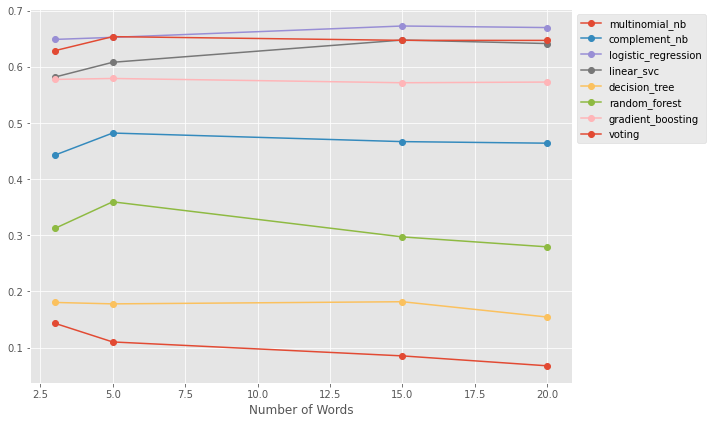

In [225]:
num_words = [20, 15, 5, 3]

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Define subplots upfront
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(2, 1, 2)

for clf_name in clf_names:
#     print(clf_name, ":\n")
    f1s = []
    for pf in prefix_list:
#         print(f"{pf}: {clf_name} - {f1_scores[pf][clf_name]}")
        f1s.append(f1_scores[pf][clf_name])
    color = next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(num_words, f1s,
            linestyle='-', marker='o', color=color, 
            label=f"{clf_name}")
#     print()
        
ax1.set_xlabel('Number of Words')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

F1 Score
- Logistic Regression 모델의 F1 스코어 값이 제일 높게 나왔다.
- 이어서 Voting, SVM, Gradient Boosting 값이 좋게 나왔다. 
- multinomial, decision tree 모델의 결과가 제일 좋지 않다.
  - decision tree 는 왜 이렇게 나쁘게 나온걸까?
- 단어 수에 따른 결과는 그렇게 크지 않다.

# 4. 딥러닝 모델과 비교해 보기

In [220]:
prefix_name = "wf"

In [173]:
# tfidf 데이터셋 --> ffn 데이터셋
def get_ffn_dataset(dataset):
    X_train = dataset["X_train"]
    y_train = dataset["y_train"]
    X_test = dataset["X_test"]
    y_test = dataset["y_test"]
    
    X_train_dense = X_train.todense()
    X_test_dense = X_test.todense()
    y_train_categorical = to_categorical(y_train, num_classes=46)
    y_test_categorical = to_categorical(y_test, num_classes=46)
    
    return X_train_dense, X_test_dense, y_train_categorical, y_test_categorical

In [221]:
# 저장된 데이터셋 가져오기
dataset = load_var(prefix_name + "_dataset")
X_train, X_test, y_train, y_test = get_ffn_dataset(dataset)

In [218]:
def build_model(input_length, vocab_size, embedding_dim):
    inputs = layers.Input(shape=(input_length,))
#     x = layers.Dense(512, activation='relu')(inputs)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(inputs)
    outputs = layers.Dense(46, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [216]:
def train_model(input_length, embedding_dim, 
                train_inputs, train_labels,
                test_inputs, test_labels,
                model_name, model_desc,
                build_model, vocab_size=8000):
    
    cb_es = callbacks.EarlyStopping(
        monitor='val_loss', mode='min', verbose=1, patience=5)
    
    cb_mc = callbacks.ModelCheckpoint(
        model_name + '.h5', monitor='val_accuracy', 
        mode='max', verbose=1, save_best_only=True)
    
    model = build_model(
        input_length=input_length, 
        vocab_size=vocab_size,
        embedding_dim=embedding_dim)
    
    history = model.fit(
        train_inputs, train_labels, 
        epochs=20, batch_size=256, 
        callbacks=[cb_es, cb_mc],
        validation_split=0.2
    )
    
    result = model.evaluate(test_inputs, test_labels)
    print(result)
    
    history_result = {
        "name": model_name,
        "history": history.history,
        "evaluation": result,
        "description": model_desc,
    }
    
    return model, history_result

In [222]:
max_len = X_train.shape[1]
embedding_dim = 128
model_name = prefix_name + "_ffn_128"
model_desc = prefix_name + "_Feed Forward Network 128"

model, history_result = train_model(max_len, embedding_dim,
                                    X_train, y_train,
                                    X_test, y_test,
                                    model_name, model_desc,
                                    build_model)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 26506)]           0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               3392896   
_________________________________________________________________
dense_33 (Dense)             (None, 46)                5934      
Total params: 3,398,830
Trainable params: 3,398,830
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
29/29 [==============================] - 1s 37ms/step - loss: 3.4820 - accuracy: 0.5317 - val_loss: 2.9432 - val_accuracy: 0.6055

Epoch 00001: val_accuracy improved from -inf to 0.60545, saving model to wf_ffn_128.h5
Epoch 2/20
29/29 [==============================] - 0s 16ms/step - loss: 2.3751 - accuracy: 0.6175 - val_loss: 1.9459 - val_accuracy: 0.5865

Epoch 00

In [223]:
save_var(history_result, model_name + "_history")

## 시각화

In [67]:
prefix_list = ["wf", "w15k", "w5k", "w3k"]

In [83]:
histories = []
for pf in prefix_list:
    histories.append(load_var(pf + "_ffn_512_256_128_history"))

In [84]:
for i, item in enumerate(histories):
    print(f"{i:2}: {item['name']} \n\t{item['description']}\n")

 0: wf_ffn_512_256_128 
	wf_Feed Forward Network 512-256-128

 1: w15k_ffn_512_256_128 
	w15k_Feed Forward Network 512-256-128

 2: w5k_ffn_512_256_128 
	w5k_Feed Forward Network 512-256-128

 3: w3k_ffn_512_256_128 
	w3k_Feed Forward Network 512-256-128



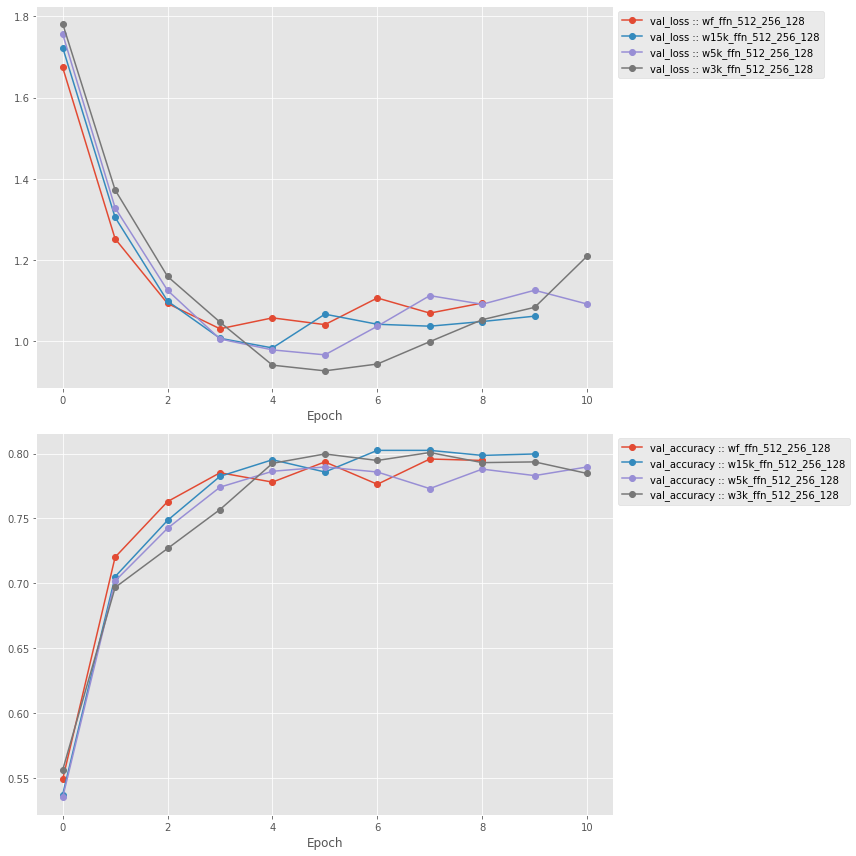

In [211]:
def plot_metrics(history, ax, metric, val_metric, label, color):
    ax.plot(history[val_metric], linestyle='-', marker='o', color=color, label=f"{val_metric} :: {label}")
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

metrics_info = [
    ('loss', 'val_loss', ax1),
    ('accuracy', 'val_accuracy', ax2)
]

for i in history_selection:
    label = histories[i]['name']
    history = histories[i]['history']
    color = next(ax1._get_lines.prop_cycler)['color']

    for metric, val_metric, ax in metrics_info:
        plot_metrics(history, ax, metric, val_metric, label, color)

plt.tight_layout()
plt.show()


- 단어 수에 따른 큰 차이는 없어보인다.

## F1 Score

In [183]:
ffn_f1s = {}
for pf in prefix_list:
    print(f"Working for {pf}")
    model = models.load_model(f"save/{pf}_ffn_512_256_128.h5")
    dataset = load_var(pf + "_dataset")
    X_train, X_test, y_train, y_test = get_ffn_dataset(dataset)
    pred = model.predict(X_test)
    pred_labels = np.argmax(pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    ffn_f1s[pf] = f1_score(y_test_labels, pred_labels, average='macro')

Working for wf
Working for w15k
Working for w5k
Working for w3k


In [201]:
save_var(ffn_f1s, "ffn_f1")

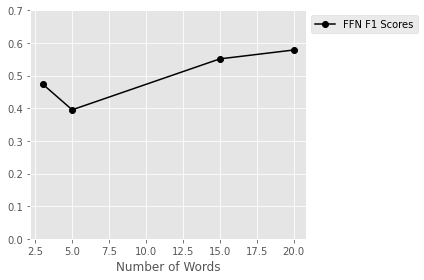

In [209]:
num_words = [20, 15, 5, 3]

plt.figure(figsize=(6, 4))
plt.style.use('ggplot')

ax1 = plt.subplot(1, 1, 1)

f1s = []
for pf in prefix_list:
    f1s.append(ffn_f1s[pf])

ax1.plot(num_words, f1s,
        linestyle='-', marker='o', color='black', 
        label=f"FFN F1 Scores")
ax1.set_ylim(0.0, 0.7)
ax1.set_xlabel('Number of Words')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Classifiers vs. FFN

In [202]:
clf_f1 = load_var("classifiers_f1")
ffn_f1 = load_var("ffn_f1")

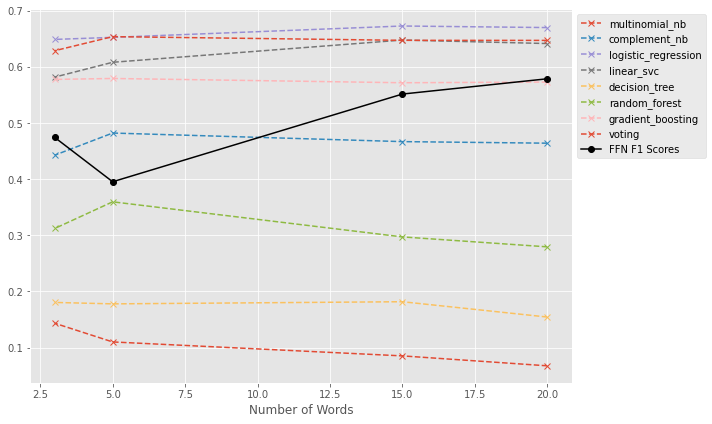

In [212]:
def plot_scores(ax, x_data, y_data, label, linestyle, marker, color):
    ax.plot(x_data, y_data, linestyle=linestyle, marker=marker, color=color, label=label)
    ax.set_xlabel('Number of Words')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
ax1 = plt.subplot(1, 1, 1)

# classifiers F1 scores
for clf_name in clf_names:
    f1s = [f1_scores[pf][clf_name] for pf in prefix_list]
    color = next(ax1._get_lines.prop_cycler)['color']
    plot_scores(ax1, num_words, f1s, clf_name, '--', 'x', color)

# FFN F1 scores
ffn_scores = [ffn_f1[pf] for pf in prefix_list]
plot_scores(ax1, num_words, ffn_scores, "FFN F1 Scores", '-', 'o', 'black')

plt.tight_layout()
plt.show()


- Complement NB 와 비슷하다. Gradient Boosting 와 Random Forest 사이 정도 된다.
- RNN, LSTM 모델이 아닌 그냥 밀집 네트워크라서 그런지 결과는 그저그런 수준이다.
